# test svm fillip

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from preprocessing import generate_balanced_data, hog_features
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time
import random

In [30]:
seed = 1
np.random.seed(seed)
random.seed(seed)

In [31]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=seed, stratify=y
)

X_train, y_train = generate_balanced_data(X_train, y_train, seed=seed)

In [32]:
# components_range = [0.9, 0.92, 0.94, 0.95, 0.99, 0.999, 0.9999]
# for n in components_range:
#     pca = PCA(n_components=n)
#     X_train_pca = pca.fit_transform(X_train)
#     svc = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
#     scores = cross_val_score(svc, X_train_pca, y_train, cv=3)
    # print(f"n_components: {n}, Cross-validation accuracy: {np.mean(scores):.2f}")

without pca

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=   8.6s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=   8.3s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=   8.4s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=   8.2s
[CV] END C=40.64809212974488, coef0=0.7473906727826023, degree=3, gamma=0.09588427629700286, kernel=poly, shrinking=False; total time=   8.5s
[CV] END C=88.69910899335613, coef0=0.09902479244233042, degree=4, gamma=0.09290834723332915, kernel=poly, shrinking=True; total time=  10.7s
[CV] END C=88.69910899335613, coef0=0.09902479244233042, degree=4, gamma=0.0929083472333

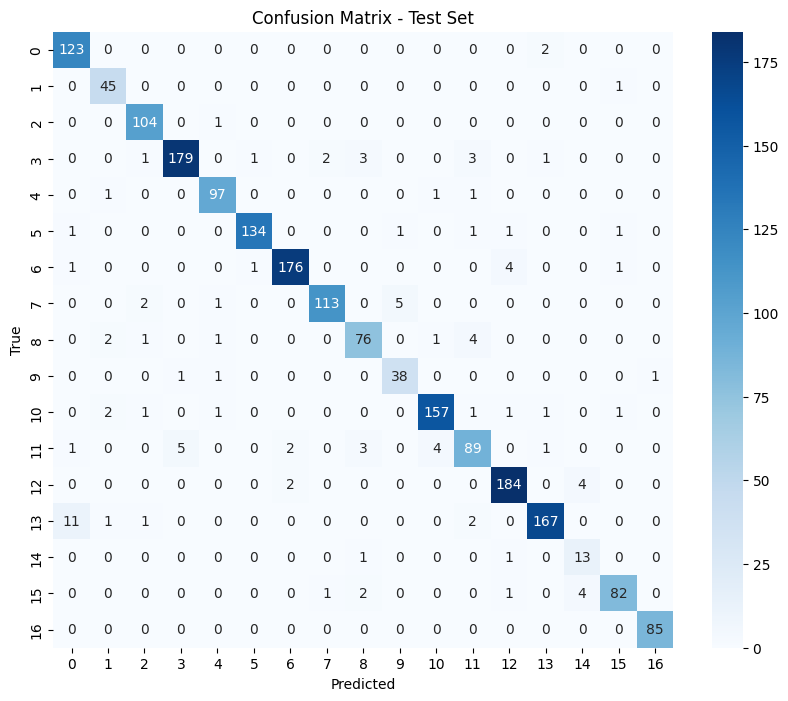

In [33]:
# extracting hog feat from our data
X_train_hog = hog_features(X_train)
X_test_hog = hog_features(X_test)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

svc = SVC(random_state=seed)
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, n_iter=5,
    cv=5, n_jobs=1, verbose=2, random_state=seed, scoring='accuracy'
)
time_start = time()
random_search.fit(X_train_hog_scaled, y_train)
print(f"Random Search took {time() - time_start:.2f} seconds")
print(f"Best Parameters: {random_search.best_params_}")

best_svc = random_search.best_estimator_

y_test_pred = best_svc.predict(X_test_hog_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

with pca

Data went from (12920, 576) to (12920, 191)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=73.54841376018594, coef0=0.19086464426541982, degree=3, gamma=0.0035738561411812852, kernel=poly, shrinking=False; total time=   2.5s
[CV] END C=73.54841376018594, coef0=0.19086464426541982, degree=3, gamma=0.0035738561411812852, kernel=poly, shrinking=False; total time=   2.6s
[CV] END C=73.54841376018594, coef0=0.19086464426541982, degree=3, gamma=0.0035738561411812852, kernel=poly, shrinking=False; total time=   2.6s
[CV] END C=73.54841376018594, coef0=0.19086464426541982, degree=3, gamma=0.0035738561411812852, kernel=poly, shrinking=False; total time=   2.7s
[CV] END C=73.54841376018594, coef0=0.19086464426541982, degree=3, gamma=0.0035738561411812852, kernel=poly, shrinking=False; total time=   2.5s
[CV] END C=57.8032977376344, coef0=0.17448672362689344, degree=4, gamma=0.018209427867643832, kernel=poly, shrinking=True; total time=   6.8s
[CV] END C=57.8032977376344, 

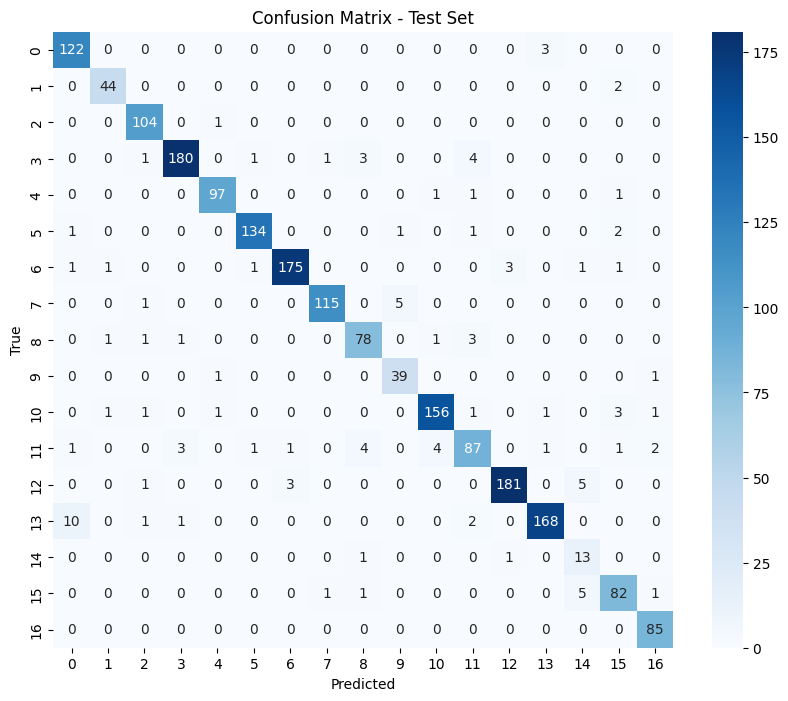

In [34]:
# extracting hog feat from our data
X_train_hog = hog_features(X_train)
X_test_hog = hog_features(X_test)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_test_hog_scaled = scaler.transform(X_test_hog)

# decompose the data while keeping 95% of the variance
pca = PCA(n_components=0.95, random_state=seed)
X_train_pca = pca.fit_transform(X_train_hog_scaled)
X_test_pca = pca.transform(X_test_hog_scaled)

print(f"Data went from {X_train_hog_scaled.shape} to {X_train_pca.shape}")

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

svc = SVC(random_state=seed)
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, n_iter=5,
    cv=5, n_jobs=1, verbose=2, random_state=seed, scoring='accuracy'
)
time_start = time()
random_search.fit(X_train_pca, y_train)
print(f"Random Search took {time() - time_start:.2f} seconds")
print(f"Best Parameters: {random_search.best_params_}")

best_svc = random_search.best_estimator_

y_test_pred = best_svc.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
